In [105]:
# LIST OF UPDATES
#
# Added bias (constant) to each linear layer
# Switched to using equivalent keras optimizer - SGD 
# Moved loss calculation to an independent function
# Switched to defining the network as Keras layers(!)
# Add tf.function to training loop - 10x speed increase(!)
# Switch to calculating gradients with keras 'trainable_weight' vs tf 'variables' 
# Tried using Keras Model.fit but order of magnitude slower than custom loop!
# Switch to train/val/test -> Showed that validation accuracy peaks at about 55% Training accuracy :(
# Switch to MeanSquaredError as loss function (But this is not a good error for classification)
# Add callback support to custom training loop
# Early completion based on validation changes
# Switch to correct method of regularisation with L2 Loss
# Addition of Dropout for regularisation
# Batch support (improves regularisation)
# Tried various train/test/val combinations - results are very sensitive to this.
# Tried various activation functions - "elu" seems best (not sure why yet)
# Switched to BinaryCrossEntropy loss function from keras
# Switched to Adam optimiser with scheduled learning
# Utilised log x-scale to compare model plot results
# Switch to "relu" activation function on hidden nodes - good for variables in 0 to 1 range.
# Add Accuracy as a metric
# Add multiple plots to compare metrics
# Switch to Hinge loss function- better for penalising wrong sign!
# Switch to tanh activation function and -1/1 labels (for Hinge)
# Initialise variables with "he-uniform" - better for relu?
# Regularisation after the activiation function, using Lamda to control how much impact.
# TODO : Represent data using windowing method


In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import numpy as np
import pandas as pd

import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils
from marketinsights.api.model import MarketInsightsModel
from marketinsights.remote.ml import MIAssembly

from tqdm import tqdm, trange
from functools import partialmethod

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt


tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

2023-05-21 11:57:18.840192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 11:57:18.975875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-21 11:57:18.975904: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-21 11:57:20.465982: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [141]:
#DATASET_ID1 = "dbaab93d94795145539e595fab79f2d4"  # DOW
#DATASET_ID1 = "4234f0f1b6fcc17f6458696a6cdf5101"  # DOW
DATASET_ID1 = "09dcbc101dd03d999a479baa924901b3" # 2023 - Corrected 
DATASET_ID1 = "1f0ee1144486054fa56d65ce71b04110" # 2023 All 
NUM_FEATURES = (2 * 4) + 1

assembly = MIAssembly(secret="marketinsights-k8s-cred")

# Dataset
ds, descriptor = assembly.get_dataset_by_id(DATASET_ID1, debug=False)
ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2542 entries, 2013-01-02 15:00:00-05:00 to 2023-03-17 15:00:00-04:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2542 non-null   float64
 1   1       2542 non-null   float64
 2   2       2542 non-null   float64
 3   3       2542 non-null   float64
 4   4       2542 non-null   float64
 5   5       2542 non-null   float64
 6   6       2542 non-null   float64
 7   7       2542 non-null   float64
 8   8       2542 non-null   float64
 9   9       2542 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 218.5 KB


In [142]:
# Flip labels for Hinge loss function
labels = ds[9]
labels[labels == 0] = -1
ds[9] = labels
ds

,0,1,2,3,4,5,6,7,8,9
Date_Time,,,,,,,,,,
2013-01-02 15:00:00-05:00,0.390854,0.826284,0.199852,0.508756,0.504133,1.000000,0.000000,0.629408,0.051259,1
2013-01-03 15:00:00-05:00,0.766445,1.000000,0.586159,0.943148,0.943148,0.944016,0.000000,0.487062,0.108321,-1
2013-01-04 15:00:00-05:00,0.096991,1.000000,0.000000,0.631825,0.632902,0.905283,0.340489,0.847693,0.043706,1
2013-01-07 15:00:00-05:00,0.078908,0.468290,0.000000,0.337985,0.337655,1.000000,0.253843,0.984516,0.071635,1
2013-01-08 15:00:00-05:00,0.000000,0.748026,0.000000,0.685708,0.685012,1.000000,0.344723,0.518904,0.068146,1
...,...,...,...,...,...,...,...,...,...,...
2023-03-13 15:00:00-04:00,0.292194,0.735428,0.000000,0.646302,0.645247,1.000000,0.585004,0.743016,0.256867,-1
2023-03-14 15:00:00-04:00,0.930589,1.000000,0.157061,0.346572,0.346438,0.573852,0.000000,0.303421,0.269744,1
2023-03-15 15:00:00-04:00,0.037013,0.535913,0.000000,0.463551,0.475937,1.000000,0.311513,0.828467,0.423262,1


In [143]:
dataset = tf.cast(ds, tf.float32)

all_x, all_y = dataset[:, :NUM_FEATURES], dataset[:,NUM_FEATURES:]

In [4]:
dataset = tf.cast(ds, tf.float32)

# Split into Train/Val/Test
n = len(dataset)
train_df = dataset[:1200]
val_df = dataset[1200:1300]
test_df = dataset[1300:]

# Split into features/labels
train_x, train_y = train_df[:, :NUM_FEATURES], train_df[:,NUM_FEATURES:]
val_x, val_y =  val_df[:, :NUM_FEATURES], val_df[:,NUM_FEATURES:]
test_x, test_y =  test_df[:, :NUM_FEATURES], test_df[:,NUM_FEATURES:]

2023-05-21 11:57:25.794190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-21 11:57:25.795224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-21 11:57:25.795337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-05-21 11:57:25.795437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-05-21 11:57:25.795533: W tensorflow/c

In [99]:

def batches(x, y, batch_size):
    return [(batch, x[batch*batch_size:(batch+1)*batch_size], y[batch*batch_size:(batch+1)*batch_size]) for batch in range(int(len(x) / batch_size))]


def roundTan(x):
    x = tf.nn.tanh(mlmodel(x))
    x = tf.where(x < 0, -1., x)
    x = tf.where(x > 0, 1., x)
    return x

def train(mlmodel, epochs=100000):
    
    lamda = tf.constant(0.5, tf.float32)
    
    @tf.function  # Make it fast.
    def train_on_batch(x, y):
        with tf.GradientTape() as tape:
                        
            loss = loss_fn(y_pred=tf.nn.tanh(mlmodel(x, training=True)), y_true=y) 
            regularization_loss=tf.add_n(mlmodel.losses)
            loss = loss + regularization_loss * lamda
            
            #binary_cross_entropy = metric(y_pred=y_pred, y_true=y) 
            
            #val_binary_cross_entropy = metric(y_pred=val_y_pred, y_true=val_y)
            val_loss = val_loss_fn(y_pred=tf.nn.tanh(mlmodel(val_x)), y_true=val_y) 
            
            accuracy = accuracyMetric(y_pred=roundTan(x), y_true=y)
            val_accuracy = val_accuracyMetric(y_pred=roundTan(val_x), y_true=val_y)
            
            gradients = tape.gradient(loss, mlmodel.trainable_weights)
        optimizer.apply_gradients(zip(gradients, mlmodel.trainable_weights))
        return {
            "loss":loss, 
            "val_loss": val_loss, 
            #"metric":binary_cross_entropy, 
            #"val_metric":val_binary_cross_entropy, 
            "accuracy": accuracy,
            "val_accuracy": val_accuracy,
            "regularization_loss":regularization_loss}


    logs = {}
    mlmodel.stop_training = False

    
    callbacks.on_train_begin(logs=logs)

    # Format training loop
    for epoch in range(epochs):

        callbacks.on_epoch_begin(epoch, logs=logs)
        #mlmodel.reset_states() # Not needed?

        for batch, batch_x, batch_y in batches(train_x, train_y, 40):

            callbacks.on_batch_begin(batch, logs=logs)
            callbacks.on_train_batch_begin(batch, logs=logs)

            logs = train_on_batch(batch_x, batch_y)

            callbacks.on_train_batch_end(batch, logs=logs)
            callbacks.on_batch_end(batch, logs=logs)

        callbacks.on_epoch_end(epoch, logs=logs)

        if epoch % 100 == 0:
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}, Accuracy: {logs["accuracy"]}, Val Accuracy: {logs["val_accuracy"]}')

        if mlmodel.stop_training:
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}')
            break

    callbacks.on_train_end(logs=logs)

    # Fetch the history object we normally get from keras.fit
    history_object = None
    for cb in callbacks:
        if isinstance(cb, tf.keras.callbacks.History):
            history_object = cb
    assert history_object is not None
    
    return history_object

In [101]:
TOTAL_EPOCHS = 100000

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, start_from_epoch=20, patience=10000, restore_best_weights=True)
# Set up callbacks
_callbacks = [earlyStopping]

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=1000,
      decay_rate=1,
      staircase=False)


In [90]:
histories = {}

In [81]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SquaredHinge()
val_loss_fn = tf.keras.metrics.SquaredHinge()
metric = tf.keras.losses.MeanSquaredError()
accuracyMetric = tf.keras.metrics.Accuracy()
val_accuracyMetric = tf.keras.metrics.Accuracy()

input_layer = tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu")

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        input_layer,
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

histories["64x4"] = train(mlmodel, TOTAL_EPOCHS, callbacks)

TypeError: train() takes from 1 to 2 positional arguments but 3 were given

In [102]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

optimizer = tf.keras.optimizers.Adam(lr_schedule)
loss_fn = tf.keras.losses.SquaredHinge()
val_loss_fn = tf.keras.metrics.SquaredHinge()
metric = tf.keras.losses.MeanSquaredError()
accuracyMetric = tf.keras.metrics.Accuracy()
val_accuracyMetric = tf.keras.metrics.Accuracy()
callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=True, model=mlmodel)
    

histories["64x4+DO+Reg:Lam.5"] = train(mlmodel, TOTAL_EPOCHS)

Step 0 - Training Loss: 2.1604199409484863, Val Loss: 1.5460373163223267, Accuracy: 0.5224999785423279, Val Accuracy: 0.5
Step 100 - Training Loss: 1.2261258363723755, Val Loss: 1.044263243675232, Accuracy: 0.5235230922698975, Val Accuracy: 0.5130000114440918
Step 200 - Training Loss: 1.1378231048583984, Val Loss: 1.0228962898254395, Accuracy: 0.5229311585426331, Val Accuracy: 0.5065323114395142
Step 300 - Training Loss: 1.0927234888076782, Val Loss: 1.0156069993972778, Accuracy: 0.5227879285812378, Val Accuracy: 0.5043621063232422
Step 400 - Training Loss: 1.0717097520828247, Val Loss: 1.012011170387268, Accuracy: 0.5227161049842834, Val Accuracy: 0.5032743215560913
Step 500 - Training Loss: 1.0577818155288696, Val Loss: 1.0098631381988525, Accuracy: 0.5226730108261108, Val Accuracy: 0.5026207566261292
Step 600 - Training Loss: 1.0558445453643799, Val Loss: 1.008466362953186, Accuracy: 0.5226442217826843, Val Accuracy: 0.5021846890449524
Step 700 - Training Loss: 1.0414795875549316, V

Step 5900 - Training Loss: 1.0236152410507202, Val Loss: 1.0009685754776, Accuracy: 0.5812469720840454, Val Accuracy: 0.5324721932411194
Step 6000 - Training Loss: 0.9304224848747253, Val Loss: 1.0009523630142212, Accuracy: 0.5816670656204224, Val Accuracy: 0.5323141813278198
Step 6100 - Training Loss: 1.0307598114013672, Val Loss: 1.00093674659729, Accuracy: 0.5820287466049194, Val Accuracy: 0.5320987105369568
Step 6200 - Training Loss: 0.9985278248786926, Val Loss: 1.0009217262268066, Accuracy: 0.5823614597320557, Val Accuracy: 0.5318703055381775
Step 6300 - Training Loss: 1.022782564163208, Val Loss: 1.000907063484192, Accuracy: 0.5826982259750366, Val Accuracy: 0.5315578579902649
Step 6400 - Training Loss: 1.001082420349121, Val Loss: 1.0008928775787354, Accuracy: 0.5830341577529907, Val Accuracy: 0.5311513543128967
Step 6500 - Training Loss: 1.0459903478622437, Val Loss: 1.000879168510437, Accuracy: 0.5833899974822998, Val Accuracy: 0.5307185053825378
Step 6600 - Training Loss: 1.

Step 11800 - Training Loss: 0.9813916683197021, Val Loss: 1.0046300888061523, Accuracy: 0.5968599319458008, Val Accuracy: 0.5161287188529968
Step 11900 - Training Loss: 1.0249251127243042, Val Loss: 1.0045912265777588, Accuracy: 0.5970783829689026, Val Accuracy: 0.5158333778381348
Step 12000 - Training Loss: 1.0016077756881714, Val Loss: 1.004552960395813, Accuracy: 0.5972921252250671, Val Accuracy: 0.5155351758003235
Step 12100 - Training Loss: 1.0442721843719482, Val Loss: 1.004515290260315, Accuracy: 0.5975008010864258, Val Accuracy: 0.5152419209480286
Step 12200 - Training Loss: 1.019212007522583, Val Loss: 1.0044783353805542, Accuracy: 0.5977046489715576, Val Accuracy: 0.514953076839447
Step 12300 - Training Loss: 0.9353982210159302, Val Loss: 1.0044418573379517, Accuracy: 0.5979107618331909, Val Accuracy: 0.5146689414978027
Step 12400 - Training Loss: 0.9555171132087708, Val Loss: 1.0044060945510864, Accuracy: 0.598120391368866, Val Accuracy: 0.5143893957138062
Step 12500 - Train

Step 17700 - Training Loss: 0.9772413372993469, Val Loss: 1.0034708976745605, Accuracy: 0.6056033372879028, Val Accuracy: 0.5097238421440125
Step 17800 - Training Loss: 0.9901251196861267, Val Loss: 1.0035910606384277, Accuracy: 0.6056948304176331, Val Accuracy: 0.5096691846847534
Step 17900 - Training Loss: 0.9792293310165405, Val Loss: 1.0037130117416382, Accuracy: 0.6057878136634827, Val Accuracy: 0.5096151828765869
Step 18000 - Training Loss: 1.005190134048462, Val Loss: 1.0039007663726807, Accuracy: 0.6058765053749084, Val Accuracy: 0.5095617771148682
Step 18100 - Training Loss: 0.9668118953704834, Val Loss: 1.004080891609192, Accuracy: 0.605963408946991, Val Accuracy: 0.5095089673995972
Step 18200 - Training Loss: 1.0035457611083984, Val Loss: 1.0042569637298584, Accuracy: 0.6060572862625122, Val Accuracy: 0.5094566941261292
Step 18300 - Training Loss: 0.9801034927368164, Val Loss: 1.0044523477554321, Accuracy: 0.6061475872993469, Val Accuracy: 0.5094050168991089
Step 18400 - Tra

Text(0.5, 0, 'Epochs')

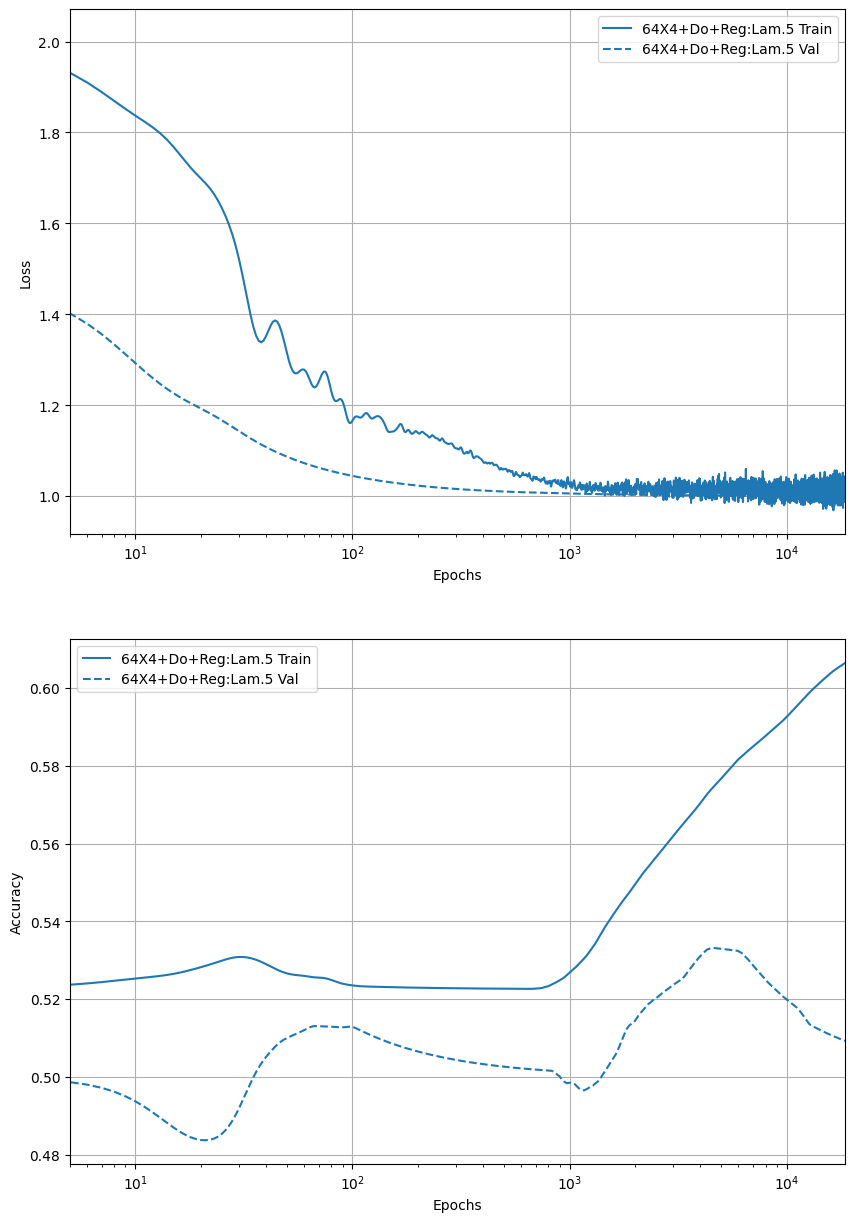

In [104]:
plt.rcParams['figure.figsize'] = [10, 15]

# PLOT histories
plt.subplot(211)
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10).plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.9, 1.1])
plt.xlabel("Epochs")

plt.subplot(212)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10).plot(histories)
#plotter.plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.5, 0.55])
plt.xlabel("Epochs")





In [50]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(train_x))).numpy()), ppl.onehot(train_y.numpy()), threshold=0.5)

Won : 874.0
Lost : 326.0
Total : 1200.0
Diff : 548.0
Edge : 45.666666666666664%
Information Coefficient : 0.4566667079925537


0.72833335

In [51]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(val_x))).numpy()), ppl.onehot(val_y.numpy()), threshold=0.5)

Won : 58.0
Lost : 42.0
Total : 100.0
Diff : 16.0
Edge : 16.0%
Information Coefficient : 0.15999996662139893


0.58

In [52]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(test_x))).numpy()), ppl.onehot(test_y.numpy()), threshold=.50)

Won : 46.0
Lost : 41.0
Total : 87.0
Diff : 5.0
Edge : 5.747126436781609%
Information Coefficient : 0.057471275329589844


0.52873564

In [92]:
tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_pred=mlmodel(val_x), y_true=toSigmoid(val_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.69271004>

In [91]:
tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_pred=baseline, y_true=toSigmoid(val_y))

<tf.Tensor: shape=(), dtype=float64, numpy=0.6941605066964598>

In [101]:
baseline = [np.sum(toSigmoid(train_y)==1)/len(train_y)]*len(test_y)

In [102]:
tf.keras.metrics.BinaryAccuracy()(y_pred=baseline, y_true=toSigmoid(test_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.43678162>

In [103]:
tf.keras.metrics.BinaryAccuracy()(y_pred=tf.nn.sigmoid(mlmodel(test_x)), y_true=toSigmoid(test_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.55172414>

In [49]:
def toSigmoid(x):
    return tf.where(x<0, 0., 1.)

In [74]:
mlmodel.save("Good_MLPx4+BN+DO_model-II")

INFO:tensorflow:Assets written to: Good_MLPx4+BN+DO_model-II/assets


In [193]:
modelName = "Good_MLPx4+BN+DO_model-II"
mlmodel = tf.keras.models.load_model(modelName)

Actual data ratio: 48.44% Positive, 51.56% Negative
Prediction data ratio: 55.51% Positive, 44.49% Negative

Classification Metrics

Won : 679
Lost : 663
Total : 1342
Diff : 16

Accuracy : 50.60%
Information Coefficient (Edge): 1.19%
Expected Value (Annualised): 1862.38%

Precision: Of all the predicted Buys/Sells, how many were correct?
Precision (Buy) : 49.13%
Precision (Sell): 52.43%

Recall: Of all the actual Buys/Sells, how many were correct?
Recall (Buy): 56.31%
Recall (Sell): 45.23%

F1 Score: Harmonic mean of Precision and Recall for the Buys/Sells
F1 Score (Buy): 52.47%
F1 Score (Sell): 48.56%


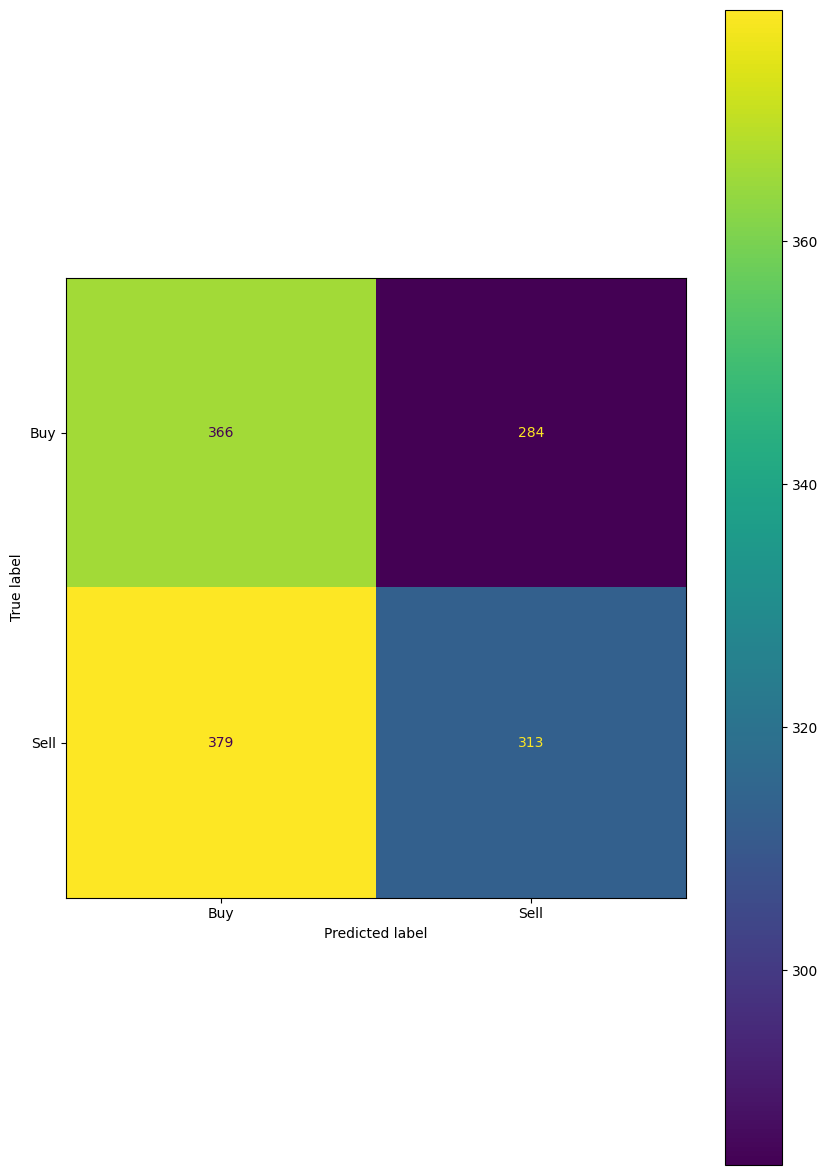

In [194]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

pred = pd.DataFrame(roundTan(all_x[1200:]).numpy().flatten(), index=ds.index[1200:])
true = pd.DataFrame(all_y[1200:].numpy().flatten(), index=ds.index[1200:])

print(f"Actual data ratio: {len(true.values[true>0])/len(true):.2%} Positive, {len(true.values[true<0])/len(true):.2%} Negative")
print(f"Prediction data ratio: {len(pred.values[pred>0])/len(pred):.2%} Positive, {len(pred.values[pred<0])/len(pred):.2%} Negative")

im = InsightManager(None)
im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"actual":true[0], "predictions":pred[0], "noHold":True, "returnsData":False}))
#im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"baseline":p.assets[0], "noHold":True}))

results = im.generateInsights()

In [195]:
pred.to_pickle(f"{modelName}-Copy1.5-all.pkl")

Actual data ratio: 52.25% Positive, 47.75% Negative
Prediction data ratio: 56.92% Positive, 43.08% Negative

Classification Metrics

Won : 874
Lost : 326
Total : 1200
Diff : 548

Accuracy : 72.83%
Information Coefficient (Edge): 45.67%
Expected Value (Annualised): 15417.40%

Precision: Of all the predicted Buys/Sells, how many were correct?
Precision (Buy) : 72.04%
Precision (Sell): 73.89%

Recall: Of all the actual Buys/Sells, how many were correct?
Recall (Buy): 78.47%
Recall (Sell): 66.67%

F1 Score: Harmonic mean of Precision and Recall for the Buys/Sells
F1 Score (Buy): 75.11%
F1 Score (Sell): 70.09%


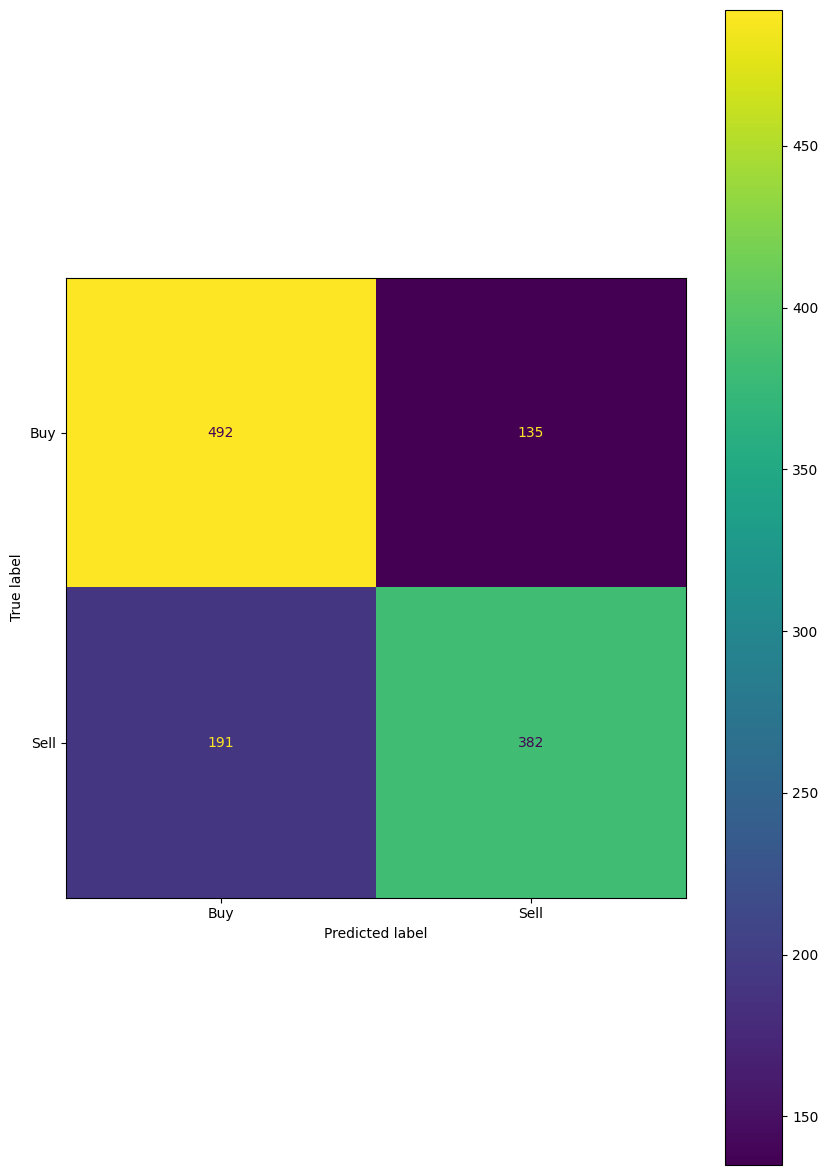

In [162]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

pred = pd.DataFrame(roundTan(train_x).numpy().flatten(), index=ds.index[:1200])
true = pd.DataFrame(train_y.numpy().flatten(), index=ds.index[:1200])

print(f"Actual data ratio: {len(true.values[true>0])/len(true):.2%} Positive, {len(true.values[true<0])/len(true):.2%} Negative")
print(f"Prediction data ratio: {len(pred.values[pred>0])/len(pred):.2%} Positive, {len(pred.values[pred<0])/len(pred):.2%} Negative")

im = InsightManager(None)
im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"actual":true[0], "predictions":pred[0], "noHold":True, "returnsData":False}))
#im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"baseline":p.assets[0], "noHold":True}))

results = im.generateInsights()


Actual data ratio: 50.00% Positive, 50.00% Negative
Prediction data ratio: 60.00% Positive, 40.00% Negative

Classification Metrics

Won : 58
Lost : 42
Total : 100
Diff : 16

Accuracy : 58.00%
Information Coefficient (Edge): 16.00%
Expected Value (Annualised): 7475.54%

Precision: Of all the predicted Buys/Sells, how many were correct?
Precision (Buy) : 56.67%
Precision (Sell): 60.00%

Recall: Of all the actual Buys/Sells, how many were correct?
Recall (Buy): 68.00%
Recall (Sell): 48.00%

F1 Score: Harmonic mean of Precision and Recall for the Buys/Sells
F1 Score (Buy): 61.82%
F1 Score (Sell): 53.33%


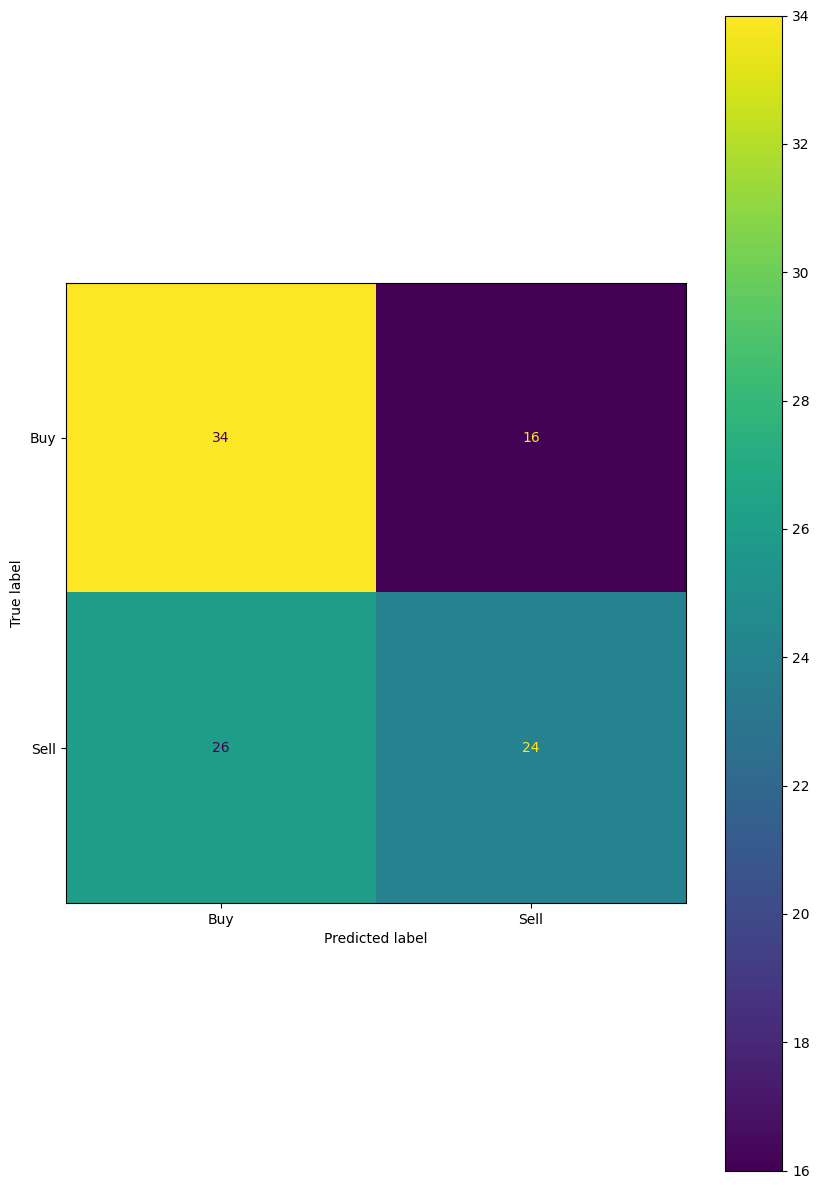

In [164]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

pred = pd.DataFrame(roundTan(val_x).numpy().flatten(), index=ds.index[1200:1300])
true = pd.DataFrame(val_y.numpy().flatten(), index=ds.index[1200:1300])

print(f"Actual data ratio: {len(true.values[true>0])/len(true):.2%} Positive, {len(true.values[true<0])/len(true):.2%} Negative")
print(f"Prediction data ratio: {len(pred.values[pred>0])/len(pred):.2%} Positive, {len(pred.values[pred<0])/len(pred):.2%} Negative")

im = InsightManager(None)
im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"actual":true[0], "predictions":pred[0], "noHold":True, "returnsData":False}))
#im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"baseline":p.assets[0], "noHold":True}))

results = im.generateInsights()

Actual data ratio: 43.68% Positive, 56.32% Negative
Prediction data ratio: 60.92% Positive, 39.08% Negative

Classification Metrics

Won : 46
Lost : 41
Total : 87
Diff : 5

Accuracy : 52.87%
Information Coefficient (Edge): 5.75%
Expected Value (Annualised): 4690.83%

Precision: Of all the predicted Buys/Sells, how many were correct?
Precision (Buy) : 47.17%
Precision (Sell): 61.76%

Recall: Of all the actual Buys/Sells, how many were correct?
Recall (Buy): 65.79%
Recall (Sell): 42.86%

F1 Score: Harmonic mean of Precision and Recall for the Buys/Sells
F1 Score (Buy): 54.95%
F1 Score (Sell): 50.60%


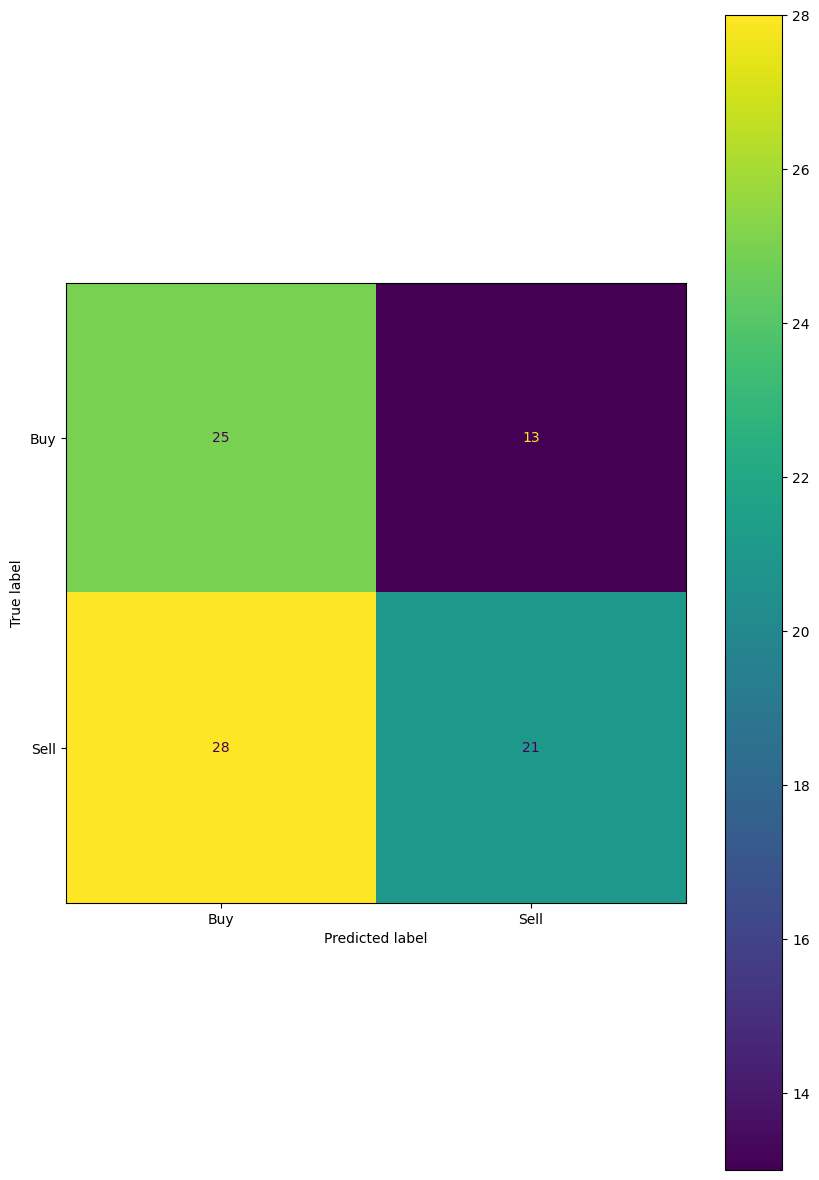

In [166]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

pred = pd.DataFrame(roundTan(test_x).numpy().flatten(), index=ds.index[1300:1387])
true = pd.DataFrame(test_y.numpy().flatten(), index=ds.index[1300:1387])

print(f"Actual data ratio: {len(true.values[true>0])/len(true):.2%} Positive, {len(true.values[true<0])/len(true):.2%} Negative")
print(f"Prediction data ratio: {len(pred.values[pred>0])/len(pred):.2%} Positive, {len(pred.values[pred<0])/len(pred):.2%} Negative")

im = InsightManager(None)
im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"actual":true[0], "predictions":pred[0], "noHold":True, "returnsData":False}))
#im.addInsightGenerator(im.createInsightGenerator("ConfusionMatrix", opts={"baseline":p.assets[0], "noHold":True}))

results = im.generateInsights()

In [140]:
pred.to_pickle("Great_MLPx4+BN+DO_model-Copy1.5-test.pkl")

In [158]:
ds[:1200]

,0,1,2,3,4,5,6,7,8,9
Date_Time,,,,,,,,,,
2013-01-02 15:00:00-05:00,0.390854,0.826284,0.199852,0.508756,0.504133,1.000000,0.000000,0.629408,0.051259,1
2013-01-03 15:00:00-05:00,0.766445,1.000000,0.586159,0.943148,0.943148,0.944016,0.000000,0.487062,0.108321,-1
2013-01-04 15:00:00-05:00,0.096991,1.000000,0.000000,0.631825,0.632902,0.905283,0.340489,0.847693,0.043706,1
2013-01-07 15:00:00-05:00,0.078908,0.468290,0.000000,0.337985,0.337655,1.000000,0.253843,0.984516,0.071635,1
2013-01-08 15:00:00-05:00,0.000000,0.748026,0.000000,0.685708,0.685012,1.000000,0.344723,0.518904,0.068146,1
...,...,...,...,...,...,...,...,...,...,...
2017-10-24 15:00:00-04:00,0.971449,1.000000,0.571611,0.714438,0.700157,0.914344,0.000000,0.085773,0.044467,-1
2017-10-25 15:00:00-04:00,0.208631,0.774125,0.000000,0.678964,0.673016,1.000000,0.595672,0.714653,0.107544,1
2017-10-26 15:00:00-04:00,0.138005,1.000000,0.000000,0.741498,0.724262,0.827675,0.275986,0.344967,0.036925,-1


In [145]:
def accuracy(y_true, y_pred):
    return (y_true==y_pred).sum()/len(y_true)

<AxesSubplot:xlabel='Date_Time'>

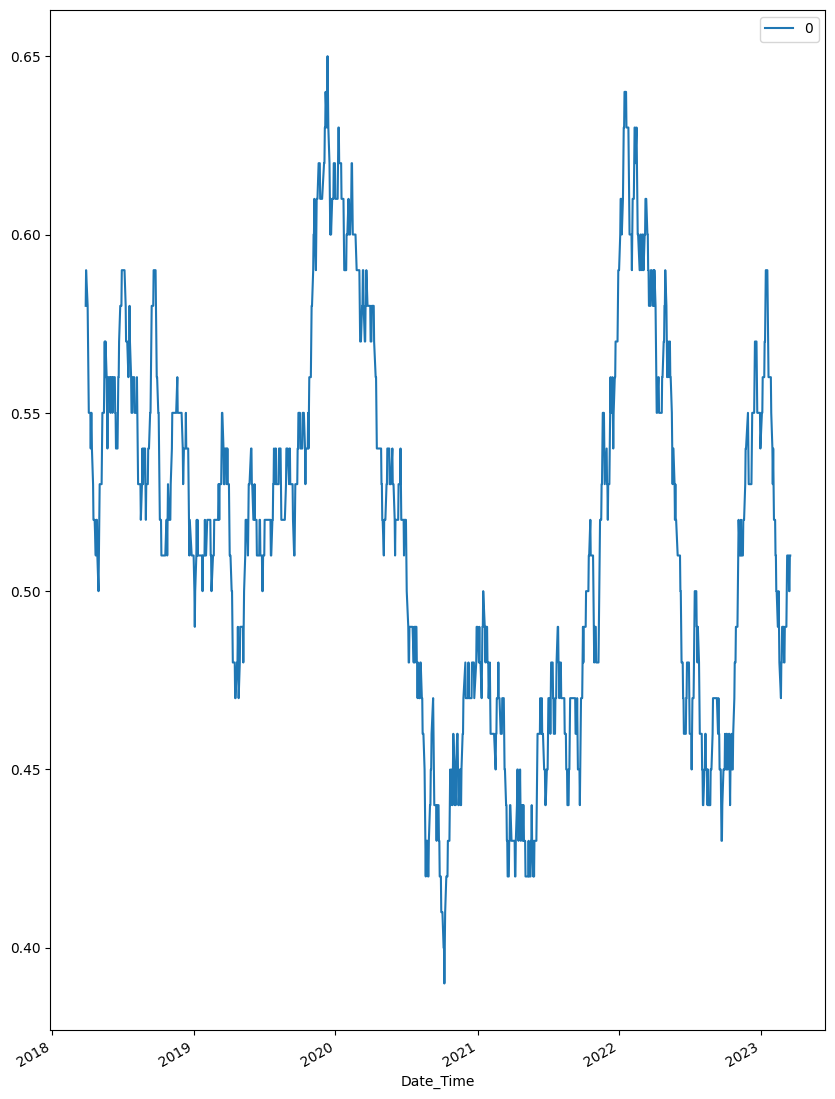

In [169]:
a = true.values
b = pred.values
acc = [accuracy(a[n:n+100], b[n:n+100]) for n in range(len(true)-100)]
pd.DataFrame(acc, index=true.index[100:]).plot()

<AxesSubplot:xlabel='Date_Time'>

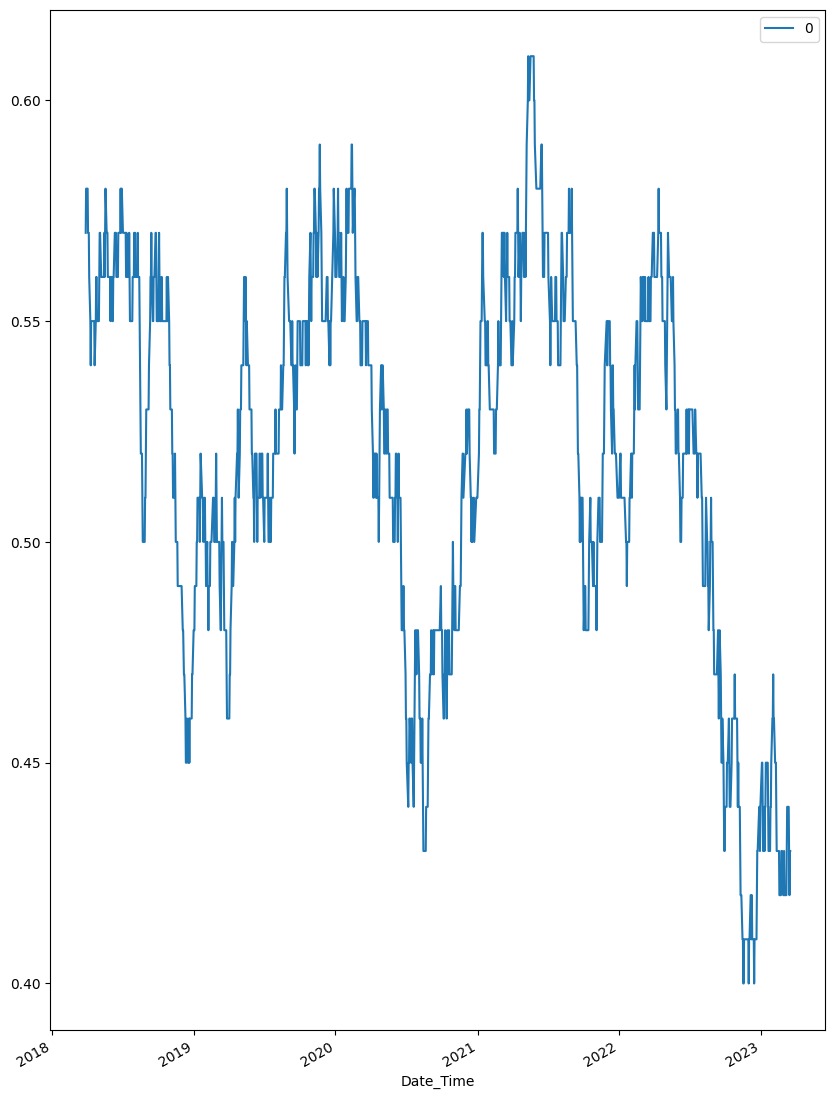

In [178]:
a = true.values
b = pred.values
acc = [accuracy(a[n:n+100], b[n:n+100]) for n in range(len(true)-100)]
pd.DataFrame(acc, index=true.index[100:]).plot()